In [1]:
%matplotlib inline

# 鑑黃大師

![md_images](../Images/porndetector.jpg?raw=true)

![md_images](../Images/pornclass.jpg?raw=true)

In [2]:
# im = cv2.imread(imgpath)
# rr = random.randint(0, 10)
# if rr % 3 == 0:
#     im = cv2.resize(im, (64, 64), interpolation=cv2.INTER_AREA)
# elif rr % 3 == 1:
#     scale = 64 / max(im.shape[:2])
#     im_org = cv2.resize(im, (int(im.shape[1] * scale), int(im.shape[0] * scale)), interpolation=cv2.INTER_AREA)
#     im = np.ones((64, 64, 3), dtype=np.float32) * 255
#     im[:im_org.shape[0], :im_org.shape[1], :] = im_org
# elif rr % 3 == 2:
#     scale = 64 / min(im.shape[:2])
#     im_org = cv2.resize(im, (int(im.shape[1] * scale), int(im.shape[0] * scale)), interpolation=cv2.INTER_AREA)
#     offset_x = 0
#     if im_org.shape[1] > 64:
#         offset_x = random.choice(range(0, im_org.shape[1] - 64))
#     offset_y = 0
#     if im_org.shape[0] > 64:
#         offset_y = random.choice(range(0, im_org.shape[0] - 64))
#     im = im_org[offset_y:offset_y + 64 , offset_x:offset_x + 64 , :]

In [3]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import math
import random
import glob
import pickle
import PIL
from PIL import Image


import cntk as C
from cntk.ops import *
from cntk.layers import *
from cntk.losses import *
from cntk.metrics import *
from cntk.debugging import *
from cntk.logging import *
from cntk.learners import *
from cntk.train import *
from cntk.device import *

# 是否使用GPU
is_gpu = True
if is_gpu:
    try_set_default_device(gpu(0))
else:
    try_set_default_device(cpu())

In [4]:
C.__version__

'2.6'

10001
5746


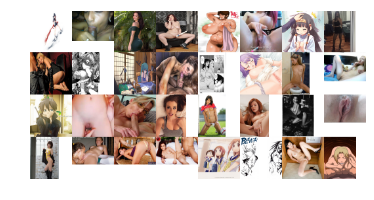

In [5]:
f1 = open('../Data/train_porn_detector64_small.pkl', 'rb')
trainData=pickle.load(f1)  
f2 = open('../Data/test_porn_detector64_small.pkl', 'rb')
testData=pickle.load(f2)  
print(len(trainData[0]))
print(len(testData[0]))

idx=0
idxs=np.arange(len(trainData[0]))
np.random.shuffle(idxs)

sample_img=np.zeros((3,64*4,64*8),dtype=np.float32)
numrows, numcols = 4, 8
height = 64
width = 64
for row in range(numrows):
    for col in range(numcols):
        y0 = row * height
        y1 = y0 + height
        x0 = col * width
        x1 = x0 + width
      
        sample_img[:,y0:y1, x0:x1]=trainData[0][idxs[idx]][::-1][:,:,:]
        idx+=1

sample_img=np.transpose(sample_img.astype(np.uint8),[1,2,0])
img=Image.fromarray(sample_img)
plt.axis('off')
plt.imshow(img)

In [6]:


def get_next_minibatch(minibatch_size):
    global idx,idxs
    features=[]
    labels=[]
    while len(features)<minibatch_size:
        features.append(trainData[0][idxs[idx]]/255.0)
        label=np.zeros(5,dtype=np.float32)
        label[trainData[1][idxs[idx]]]=1
        labels.append(label)
        idx+=1
        if idx>len(idxs)-1:
            idx=0
            np.random.shuffle(idxs)
    return np.asarray(features).astype(np.float32),np.asarray(labels).astype(np.float32)

idx1=0
idxs1=np.arange(len(testData[0]))
np.random.shuffle(idxs1)
def get_next_test_minibatch(minibatch_size):
    global idx1,idxs1
    features=[]
    labels=[]
    while len(features)<minibatch_size:
        features.append(testData[0][idxs1[idx1]]/255.0)
        label=np.zeros(5,dtype=np.float32)
        label[testData[1][idxs1[idx1]]]=1
        labels.append(label)
        idx1+=1
        if idx1>len(idxs1)-1:
            idx1=0
            np.random.shuffle(idxs1)
    return np.asarray(features).astype(np.float32),np.asarray(labels).astype(np.float32)

features_x,labels_y=get_next_minibatch(3)
print(features_x.shape)
print(labels_y.shape)

(3, 3, 64, 64)
(3, 5)


![md_images](../Images/vgg16.png?raw=true)

![md_images](../Images/global_average_pooling.png?raw=true)

In [7]:
def create_vgg16(input,num_classes=5):
    with default_options(activation=None, pad=True, bias=True):
        z = Sequential([
            For(range(2), lambda i: [
                Convolution2D((3,3), 64, name='conv1_{}'.format(i)),
                BatchNormalization(map_rank=1),
                Activation(activation=relu, name='relu1_{}'.format(i)),
            ]),
            MaxPooling((2,2), (2,2), name='pool1'),
            For(range(2), lambda i: [
                Convolution2D((3,3), 128, name='conv2_{}'.format(i)),
                BatchNormalization(map_rank=1),
                Activation(activation=relu, name='relu2_{}'.format(i)),
            ]),
            MaxPooling((2,2), (2,2), name='pool2'),
            Dropout(0.5, name='drop1'),
            For(range(3), lambda i: [
                Convolution2D((3,3), 256, name='conv3_{}'.format(i)),
                BatchNormalization(map_rank=1),
                Activation(activation=relu, name='relu3_{}'.format(i)),
            ]),
            MaxPooling((2,2), (2,2), name='pool3'),
            
            For(range(3), lambda i: [
                Convolution2D((3,3), 512, name='conv4_{}'.format(i)),
                BatchNormalization(map_rank=1),
                Activation(activation=relu, name='relu4_{}'.format(i)),
            ]),
            MaxPooling((2,2), (2,2), name='pool4'),
            Dropout(0.5, name='drop2'),
            For(range(3), lambda i: [
                Convolution2D((3,3), 512, name='conv5_{}'.format(i)),
                BatchNormalization(map_rank=1),
                Activation(activation=relu, name='relu5_{}'.format(i)),
            ]),
            MaxPooling((2,2), (2,2), name='pool5'),
            Convolution2D((1,1), 5, name='conv1x1'),
            GlobalAveragePooling( name='final_avg_pooling'),
            Dense(num_classes, name='fc1')
            ])(input)
        return z

In [8]:
feature_var = C.input_variable((3, 64, 64))
label_var = C.input_variable(5)

z=create_vgg16(feature_var,5)

loss = C.cross_entropy_with_softmax(z, label_var)

errs = C.classification_error(z, label_var)
errs5 = C.classification_error(z, label_var, topN=5)

log_number_of_parameters(z)
learning_rate=0.0001
momentum=0.95
l1_regularization_weight=0.001
l2_regularization_weight=5e-4
minibatch_size=32
num_epochs=5
        
progress_printer = ProgressPrinter(freq=50, tag='Training', num_epochs=num_epochs)
learner = adam(z.parameters, lr=learning_rate_schedule([learning_rate], UnitType.sample, num_epochs),
               momentum=momentum_as_time_constant_schedule([minibatch_size / -math.log(momentum)], epoch_size=num_epochs),
               l1_regularization_weight=l1_regularization_weight, l2_regularization_weight=l2_regularization_weight)

trainer = Trainer(z, (loss, errs), learner, progress_printer)

Training 14725731 parameters in 56 parameter tensors.


In [9]:
for epoch in range(num_epochs):
    mbs=0
    while mbs <10000//minibatch_size:
        raw_features,raw_labels = get_next_minibatch(minibatch_size)
        # 定義數據如何對應變數
        trainer.train_minibatch({feature_var:raw_features,label_var:raw_labels})
        if mbs%10==0:
            z.save('Models/porndetector_vgg16_{0}_cntk.cnn'.format(epoch))
        mbs+=1
    trainer.summarize_training_progress()
 

Learning rate per 1 samples: 0.0001
 Minibatch[   1-  50]: loss = 1.335608 * 1600, metric = 47.62% * 1600;
 Minibatch[  51- 100]: loss = 1.144046 * 1600, metric = 39.94% * 1600;
 Minibatch[ 101- 150]: loss = 1.163622 * 1600, metric = 43.81% * 1600;
 Minibatch[ 151- 200]: loss = 1.106074 * 1600, metric = 42.00% * 1600;
 Minibatch[ 201- 250]: loss = 1.038471 * 1600, metric = 36.81% * 1600;
 Minibatch[ 251- 300]: loss = 1.102531 * 1600, metric = 40.50% * 1600;
Finished Epoch[1 of 5]: [Training] loss = 1.142318 * 9984, metric = 41.61% * 9984 47.191s (211.6 samples/s);
 Minibatch[   1-  50]: loss = 0.990140 * 1600, metric = 37.12% * 1600;
 Minibatch[  51- 100]: loss = 1.033173 * 1600, metric = 38.88% * 1600;
 Minibatch[ 101- 150]: loss = 1.061680 * 1600, metric = 40.50% * 1600;
 Minibatch[ 151- 200]: loss = 0.906337 * 1600, metric = 33.62% * 1600;
 Minibatch[ 201- 250]: loss = 0.978163 * 1600, metric = 37.25% * 1600;
 Minibatch[ 251- 300]: loss = 0.922370 * 1600, metric = 33.38% * 1600;
Fin

In [10]:
test_features,test_labels = get_next_test_minibatch(minibatch_size*2)
trainer.test_minibatch({feature_var:test_features,label_var:test_labels})
print('loss:{0}',np.mean(loss.eval({feature_var:test_features,label_var:test_labels})))
trainer.summarize_test_progress()

loss:{0} 1.2095273
Finished Evaluation [1]: Minibatch[1-1]: metric = 42.19% * 64;


## 數據增強 Data Augmentation 

In [11]:
coverage = 220 
rotation_range = 150
zoom_range = 0.8
shift_range = 0.3
random_flip = 0.5

#隨機進行旋轉 縮放 位移 反轉等圖像操作
def random_transform(image, rotation_range=rotation_range, zoom_range=zoom_range, shift_range=shift_range,
                     random_flip=random_flip):
    #chw->hwc
    image = image.transpose([1, 2, 0])
    h, w = image.shape[0:2]
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - zoom_range, 1 + zoom_range)
    tx = np.random.uniform(-shift_range, shift_range) * w
    ty = np.random.uniform(-shift_range, shift_range) * h
    mat = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)
    mat[:, 2] += (tx, ty)
    new_image = cv2.warpAffine(image, mat, (w, h))  # , borderMode=cv2.BORDER_REPLICATE
 
    if np.random.random() < random_flip:
        new_image = new_image[:, ::-1]
    new_image = new_image.transpose([2, 0, 1])

    return new_image

#隨機加入標準常態分配的噪聲
def add_noise(image):
    noise=np.random.standard_normal(image.shape)*np.random.choice(np.arange(-25,25))
    image=np.clip(image+noise,0,255)
    return image

#調整明暗
def adjust_gamma(image,gamma=1.8):
    image = image.transpose([1, 2, 0])
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    image=cv2.LUT(image.astype(np.uint8), table)
    image = image.transpose([2, 0, 1])
    return image




In [12]:
def get_next_minibatch(minibatch_size):
    global idx,idxs,adjust_gamma,add_noise,random_transform,img_gray
    features=[]
    labels=[]
    while len(features)<minibatch_size:
        #加入數據增強
        img=trainData[0][idxs[idx]]
        img=add_noise(img)
        #隨機選擇亮度gamma為0.6~1.5之間數字
        gamma=np.random.choice(np.arange(0.6, 1.5, 0.05))
        img=adjust_gamma(img,gamma)
        
        features.append(img/255.0)
        label=np.zeros(5,dtype=np.float32)
        label[trainData[1][idxs[idx]]]=1
        labels.append(label)
        idx+=1
        if idx>len(idxs)-1:
            idx=0
            np.random.shuffle(idxs)
    return np.asarray(features).astype(np.float32),np.asarray(labels).astype(np.float32)

#另外初始化模型改用有數據增強的樣本來訓練
z1=create_vgg16(feature_var,5)
loss1 = C.cross_entropy_with_softmax(z1, label_var)
errs1 = C.classification_error(z1, label_var)
progress_printer1 = ProgressPrinter(freq=50, tag='Training', num_epochs=num_epochs)
learner1 = adam(z1.parameters, lr=learning_rate_schedule([learning_rate], UnitType.sample, num_epochs),
               momentum=momentum_as_time_constant_schedule([minibatch_size / -math.log(momentum)], epoch_size=num_epochs),
               l1_regularization_weight=l1_regularization_weight, l2_regularization_weight=l2_regularization_weight)

trainer1 = Trainer(z1, (loss1, errs1), learner1, progress_printer1)

In [13]:
for epoch in range(num_epochs):
    mbs=0
    while mbs <10000//minibatch_size:
        raw_features,raw_labels = get_next_minibatch(minibatch_size)
        # 定義數據如何對應變數
        trainer1.train_minibatch({feature_var:raw_features,label_var:raw_labels})
        if mbs%10==0:
            z1.save('Models/porndetector_vgg16_da_{0}_cntk.cnn'.format(epoch))
        mbs+=1
    trainer1.summarize_training_progress()


Learning rate per 1 samples: 0.0001
 Minibatch[   1-  50]: loss = 1.483526 * 1600, metric = 50.19% * 1600;
 Minibatch[  51- 100]: loss = 1.201901 * 1600, metric = 44.44% * 1600;
 Minibatch[ 101- 150]: loss = 1.133386 * 1600, metric = 40.12% * 1600;
 Minibatch[ 151- 200]: loss = 1.138402 * 1600, metric = 41.38% * 1600;
 Minibatch[ 201- 250]: loss = 1.151655 * 1600, metric = 42.19% * 1600;
 Minibatch[ 251- 300]: loss = 1.140875 * 1600, metric = 42.75% * 1600;
Finished Epoch[1 of 5]: [Training] loss = 1.200797 * 9984, metric = 43.33% * 9984 61.481s (162.4 samples/s);
 Minibatch[   1-  50]: loss = 1.090751 * 1600, metric = 42.12% * 1600;
 Minibatch[  51- 100]: loss = 1.065639 * 1600, metric = 39.81% * 1600;
 Minibatch[ 101- 150]: loss = 1.052979 * 1600, metric = 40.19% * 1600;
 Minibatch[ 151- 200]: loss = 1.016462 * 1600, metric = 38.88% * 1600;
 Minibatch[ 201- 250]: loss = 1.022813 * 1600, metric = 39.19% * 1600;
 Minibatch[ 251- 300]: loss = 0.968749 * 1600, metric = 35.88% * 1600;
Fin

In [14]:
test_features,test_labels = get_next_test_minibatch(minibatch_size*2)
trainer1.test_minibatch({feature_var:test_features,label_var:test_labels})
print('loss:{0}',np.mean(loss1.eval({feature_var:test_features,label_var:test_labels})))
trainer1.summarize_test_progress()

loss:{0} 0.90381014
Finished Evaluation [1]: Minibatch[1-1]: metric = 29.69% * 64;


![md_images](../Images/venus.jpg?raw=true)

In [41]:
imarr=cv2.imread('../Images/venus.jpg')
imarr=cv2.resize(imarr,(64,64), interpolation=cv2.INTER_AREA)
imarr=np.ascontiguousarray(np.transpose(imarr,[2,0,1]))
imarr=np.expand_dims(imarr,0)/255.0
result=softmax(z1)(imarr.astype(np.float32))
print(np.argmax(result))
print(result)

#預測結果是2屬於neutral(正常一般圖片)

2
[[0.2522203  0.07180122 0.56205726 0.08376443 0.03015676]]


![md_images](../Images/JutisfyMyLove.jpg?raw=true)

In [39]:
imarr=cv2.imread('../Images/JutisfyMyLove.jpg')
imarr=cv2.resize(imarr,(64,64), interpolation=cv2.INTER_AREA)
imarr=np.ascontiguousarray(np.transpose(imarr,[2,0,1]))
imarr=np.expand_dims(imarr,0)/255.0
result=softmax(z1)(imarr.astype(np.float32))
print(np.argmax(result))
print(result)

#預測結果是3屬於色情片等級

3
[[0.06038041 0.01520419 0.26403517 0.6121091  0.04827113]]
